# California housing price prediction by comparing different regression models

In [1]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# import SGDRegressor from sklearn to perform linear regression with stochastic gradient descent
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [39]:
#load the dataset
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
df_housing = housing.frame
df_housing.info()
df_housing.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


(20640, 9)

In [43]:
#saving last 2 rows for testing at the end
# Get the total number of rows
total_rows = df_housing.shape[0]
n_last_rows = 2

# Create the two new DataFrames
# df_first_part contains all rows except the last two
df = df_housing.iloc[:total_rows - n_last_rows]

# df_last_two contains only the last two rows
df_last_two = df_housing.iloc[total_rows - n_last_rows:]

print(df.shape)
print(df_last_two.shape)
total_rows

(20638, 9)
(2, 9)


20640

In [44]:
df_last_two.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


# Perform EDA

In [30]:
#null values
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [45]:
df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


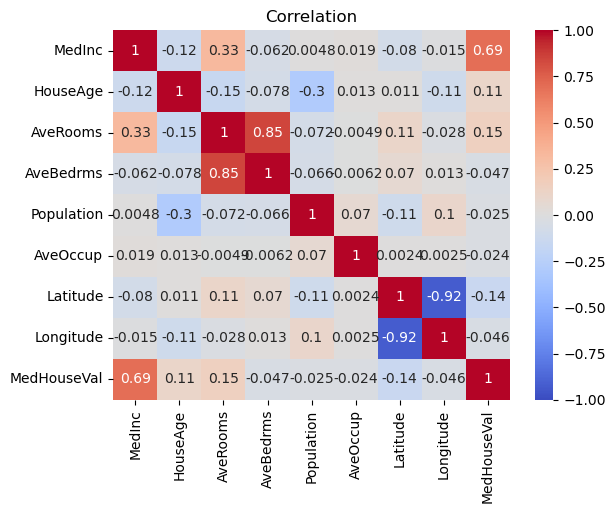

In [46]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation')
plt.show()


# Data transformation

In [47]:
#divide target and feature columns
X = df.drop('MedHouseVal',axis = 1)
y = df['MedHouseVal']

In [48]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# check the dimensions of the train & test subset using 'shape'
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (16510, 8)
y_train (16510,)
X_test (4128, 8)
y_test (4128,)


# Generalized functions

In [66]:
# Function to create model pipline 
def fit_model(name:str, model):
    pipe = Pipeline([
    ('scale', StandardScaler()), 
    (name, model)
])
    pipe.fit(X_train,y_train)
    return pipe

In [173]:
# Function to get model's MSE

def get_rmse(pipe:Pipeline):
    train_pred = pipe.predict(X_train)
    train_mse = mean_squared_error(y_train, train_pred)

    test_pred = pipe.predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)
    
#    train_rmse = round(np.sqrt(train_mse), 4)
#    test_rmse = round(np.sqrt(test_mse), 4)
    return ([train_mse, test_mse])
    

In [55]:
# define a function to get R-squared and adjusted R-squared value
def get_score(model):
    
    # score() returns the R-squared value
    r_sq = model.score(X_train, y_train)
    
    # calculate adjusted R-squared value
    # 'n' denotes number of observations in train set
    # 'shape[0]' returns number of rows 
    n = X_train.shape[0]
    
    # 'k' denotes number of variables in train set
    # 'shape[1]' returns number of columns
    k = X_train.shape[1]
    
    # calculate adjusted R-squared using the formula
    r_sq_adj = 1 - ((1-r_sq)*(n-1)/(n-k-1))
    
    # return the R-squared and adjusted R-squared value 
    return ([r_sq, r_sq_adj])

In [174]:
# create an empty dataframe to store the scores for various algorithms
score_card = pd.DataFrame(columns=['Model_Name', 'Alpha (Wherever Required)', 'l1-ratio', 'Train_MSE','Test_MSE',
                          'R-Squared','Adj. R-Squared'])

# create a function to update the score card for comparision of the scores from different algorithms
# pass the model name, model build, alpha and l1_ration as input parameters
# if 'alpha' and/or 'l1_ratio' is not specified, the function assigns '-'
def update_score_card(algorithm_name, model, alpha = '-', l1_ratio = '-'):
    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    global score_card
    key_cols = ["Model_Name"]
    
    new_row = {
        'Model_Name': algorithm_name,
        'Alpha (Wherever Required)': alpha, 
        'l1-ratio': l1_ratio, 
        'Train_MSE': get_mse(model)[0],
        'Test_MSE': get_mse(model)[1], 
        'R-Squared': get_score(model)[0], 
        'Adj. R-Squared': get_score(model)[1]
    }
   
    score_card = pd.concat([score_card, pd.DataFrame([new_row])], ignore_index=True).drop_duplicates(subset=key_cols, keep="first")
   

In [125]:
def performGridSearchCV(name, model):
    tuned_paramaters = [{'alpha':[1e-15, 1e-10, 1e-8, 1e-4,1e-3, 1e-2, 0.1, 1, 5, 10, 20, 40, 60, 80, 100]}]

    # use GridSearchCV() to find the optimal value of alpha
    # estimator: pass the ridge regression model
    # param_grid: pass the list 'tuned_parameters'
    # cv: number of folds in k-fold i.e. here cv = 10
    grid_model = GridSearchCV(estimator = model, 
                          param_grid = tuned_paramaters, 
                          cv = 10)

    fitted_model = fit_model(name,grid_model)

    return fitted_model

# Regression with different models

1. ***Simple Linear Regression***

In [175]:
linreg = fit_model('linreg',LinearRegression())


# update the dataframe 'score_card'
update_score_card(algorithm_name = 'Linear Regression', model = linreg)

score_card


/var/folders/c2/kgzx1gtn69zbvq_n_sj08vkm0000gn/T/ipykernel_90263/2187477544.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_card = pd.concat([score_card, pd.DataFrame([new_row])], ignore_index=True).drop_duplicates(subset=key_cols, keep="first")


,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
0,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162


2. ***Ridge Regression***

In [176]:
ridge = fit_model('ridge', Ridge(alpha = 1, max_iter = 500))


# update the dataframe 'score_card'
update_score_card(algorithm_name = 'Ridge Regression', model = ridge ,alpha = 1)

#score_card = score_card.iloc[:-1]

score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
0,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162
1,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162


3. ***Lasso Regression***

In [177]:
lasso = fit_model('lasso', Lasso(alpha = 0.01, max_iter = 500))


# update the dataframe 'score_card'
update_score_card(algorithm_name = 'Lasso Regression', model = lasso ,alpha = 0.01)

#score_card = score_card.iloc[:-1]

score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
0,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162
1,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162
2,Lasso Regression,0.01,-,0.527468,0.535663,0.604154,0.603962


In [109]:
# create a dataframe to store the variable names and their corresponding coefficient values.
df_lasso_coeff = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso.named_steps["lasso"].coef_})

# print the variables having the coefficient value equal to zero
# 'to_list()' converts the output to the list type
print('Insignificant variables obtained from Lasso Regression when alpha is 0.01')
df_lasso_coeff.Variable[df_lasso_coeff.Coefficient == 0].to_list()

Insignificant variables obtained from Lasso Regression when alpha is 0.01


['Population']

4. ***Elastic Net Regression***

In [178]:
elastic = fit_model('elastic', ElasticNet(alpha = 0.1, l1_ratio = 0.01, max_iter = 500))

# update the dataframe 'score_card'
update_score_card(algorithm_name = 'Elastic Net Regression', model = elastic ,alpha = 0.1,l1_ratio = 0.01)

score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
0,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162
1,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162
2,Lasso Regression,0.01,-,0.527468,0.535663,0.604154,0.603962
3,Elastic Net Regression,0.1,0.01,0.573185,0.577013,0.569845,0.569636


5. ***GridSearch CV***

***Ridge regression with optimal alpha (from Gridsearch CV)***

In [179]:
ridge_grid_model = performGridSearchCV('grid_ridge', Ridge())

ridge_grid_model.named_steps["grid_ridge"].best_params_

{'alpha': 1e-15}

In [180]:
# update the dataframe 'score_card'
update_score_card(algorithm_name = 'Ridge (Using GridSearch) ', model = ridge_grid_model ,alpha = 1e-15)

score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
0,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162
1,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162
2,Lasso Regression,0.01,-,0.527468,0.535663,0.604154,0.603962
3,Elastic Net Regression,0.1,0.01,0.573185,0.577013,0.569845,0.569636
4,Ridge (Using GridSearch),0.0,-,0.521874,0.544181,0.608352,0.608162


***Lasso regression with optimal alpha (from Gridsearch CV)***

In [181]:
lasso_grid_model = performGridSearchCV('lasso_grid', Lasso())
lasso_grid_model.named_steps["lasso_grid"].best_params_

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.747e+01, tolerance: 1.988e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.224e+01, tolerance: 1.993e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+01, toler

{'alpha': 0.001}

In [182]:
# update the dataframe 'score_card'
update_score_card(algorithm_name = 'Lasso (Using GridSearch) ', model = lasso_grid_model ,alpha = 0.001)

score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
0,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162
1,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162
2,Lasso Regression,0.01,-,0.527468,0.535663,0.604154,0.603962
3,Elastic Net Regression,0.1,0.01,0.573185,0.577013,0.569845,0.569636
4,Ridge (Using GridSearch),0.0,-,0.521874,0.544181,0.608352,0.608162
5,Lasso (Using GridSearch),0.001,-,0.521931,0.542579,0.608309,0.608119


***Elastic Net regression with optimal alpha (from Gridsearch CV)***

In [183]:
tuned_paramaters = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 40, 60],
                      'l1_ratio':[0.0001, 0.0002, 0.001, 0.01, 0.1, 0.2]}

# use GridSearchCV() to find the optimal value of alpha and l1_ratio
# estimator: pass the elastic net regression model
# param_grid: pass the list 'tuned_parameters'
# cv: number of folds in k-fold i.e. here cv = 10
elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                          param_grid = tuned_paramaters, 
                          cv = 10)

enet_grid_model = fit_model('elastic_grid',elastic_grid)

enet_grid_model.named_steps["elastic_grid"].best_params_

{'alpha': 0.001, 'l1_ratio': 0.2}

In [168]:
#score_card = score_card.iloc[:-1]
#score_card = score_card.drop(index=4)
score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
0,Lasso Regression,0.01,-,0.527468,0.535663,0.604154,0.603962
1,Lasso (Using GridSearch),0.001,-,0.521931,0.542579,0.608309,0.608119
2,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162
3,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162


In [184]:

update_score_card(algorithm_name = 'ElasticNet (Using GridSearch) ', model = enet_grid_model,alpha = 0.001,l1_ratio=0.2)


score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
2,Lasso Regression,0.01,-,0.527468,0.535663,0.604154,0.603962
5,Lasso (Using GridSearch),0.001,-,0.521931,0.542579,0.608309,0.608119
6,ElasticNet (Using GridSearch),0.001,0.2,0.521903,0.543370,0.608330,0.608140
1,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162
0,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162
4,Ridge (Using GridSearch),0.0,-,0.521874,0.544181,0.608352,0.608162
3,Elastic Net Regression,0.1,0.01,0.573185,0.577013,0.569845,0.569636


In [196]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = fit_model('gbr', GradientBoostingRegressor(random_state=42))

# update the dataframe 'score_card'
update_score_card(algorithm_name = 'Gradient Boosting Regressor', model = gbr)



,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
0,Lasso Regression,0.01,-,0.527468,0.535663,0.604154,0.603962
1,Lasso (Using GridSearch),0.001,-,0.521931,0.542579,0.608309,0.608119
2,ElasticNet (Using GridSearch),0.001,0.2,0.521903,0.543370,0.608330,0.608140
3,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162
4,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162
5,Ridge (Using GridSearch),0.0,-,0.521874,0.544181,0.608352,0.608162
6,Elastic Net Regression,0.1,0.01,0.573185,0.577013,0.569845,0.569636
7,Gradient Boosting Regressor,-,-,0.259482,0.277871,0.805268,0.805174


In [197]:
score_card = score_card.sort_values(by="Test_MSE")
score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,Train_MSE,Test_MSE,R-Squared,Adj. R-Squared
7,Gradient Boosting Regressor,-,-,0.259482,0.277871,0.805268,0.805174
0,Lasso Regression,0.01,-,0.527468,0.535663,0.604154,0.603962
1,Lasso (Using GridSearch),0.001,-,0.521931,0.542579,0.608309,0.608119
2,ElasticNet (Using GridSearch),0.001,0.2,0.521903,0.543370,0.608330,0.608140
3,Ridge Regression,1,-,0.521874,0.544142,0.608352,0.608162
4,Linear Regression,-,-,0.521874,0.544181,0.608352,0.608162
5,Ridge (Using GridSearch),0.0,-,0.521874,0.544181,0.608352,0.608162
6,Elastic Net Regression,0.1,0.01,0.573185,0.577013,0.569845,0.569636


# Result

***Lasso Regression seems to be the best model for this prediction***

# Deployment

In [198]:
def predict_housing_price(house):
    """
    Function to predict the price costs of a new house.
    
    Returns:
    - Prediction
    """
    # Create a DataFrame with the new patient's data
    house_df = pd.DataFrame([house])

    # Make the prediction using the trained model
    prediction = gbr.predict(house_df)

    return prediction[0]

In [199]:
#Pretend we get a new house details
new_house = {
    'MedInc': 1.8672,
    'HouseAge': 18.0,
    'AveRooms': 5.329,
    'AveBedrms': 1.172,
    'Population': 741,
    'AveOccup': 2.123,
    'Latitude': 39.43,
    'Longitude': -121.32
}

new_house2 = {
    'MedInc': 2.3886,
    'HouseAge': 16.0,
    'AveRooms': 5.2547,
    'AveBedrms': 1.162264,
    'Population': 1387,
    'AveOccup': 2.6169,
    'Latitude': 39.37,
    'Longitude': -121.24
}

prediction = predict_housing_price(new_house2)

print(f'MedHouseVal for the new house: ${prediction}')

MedHouseVal for the new house: $0.8165725102178497


In [185]:
df_last_two.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894
